# Create train_data.csv

In [47]:
import os
from pathlib import Path
import pandas as pd

In [50]:
path_cosmenet = Path("/home/music/Desktop/measure_model/data/cosmenet_test")

In [45]:
df = []
for root, directories, files in os.walk(path_cosmenet):
    for file in files:
        classes = Path(root).name
        df.append([file, classes])

In [48]:
df_pd = pd.DataFrame(df, columns=['image_name', 'id_product'])

In [52]:
df_pd.to_csv(path_cosmenet / 'train_data.csv', index=False)

# Create Dataset

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

import pandas as pd

from PIL import Image
from pathlib import Path
import random

In [2]:
class CosmenetDataset_Triplet():
    def __init__(self, df: pd, path: Path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df.iloc[:, 0].values
            self.labels = df.iloc[:, 1].values
            self.index = df.index.values 
    
    def full_path(self, label,  image_name):
        return self.path / str(label) / image_name
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = self.full_path(self.labels[item], anchor_image_name)
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert('RGB')
        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_image_name = self.images[positive_item]
            positive_image_path = self.full_path(self.labels[positive_item], positive_image_name)
            positive_img = Image.open(positive_image_path).convert('RGB')
            #positive_img = self.images[positive_item].reshape(28, 28, 1)
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_image_name = self.images[negative_item]
            negative_image_path = self.full_path(self.labels[negative_item], negative_image_name)
            negative_img = Image.open(negative_image_path).convert('RGB')
            #negative_img = self.images[negative_item].reshape(28, 28, 1)
            if self.transform!=None:
                anchor_img = (self.transform(anchor_img)*255).int()
                positive_img = (self.transform(positive_img) *255).int()
                negative_img = (self.transform(negative_img)*255).int()
        return anchor_img, positive_img, negative_img, anchor_label

In [3]:
train_data_path = Path("/app/nfs_clientshare/mew/project/Similarity_model/data/cosmenet_test")
train_data= pd.read_csv(train_data_path / 'train_data.csv') # [imag_path, label]
def get_train_dataset(IMAGE_SIZE):
    trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), antialias=False)])
    train_dataset = CosmenetDataset_Triplet(train_data, path=train_data_path, train=True, transform=trans)
    return train_dataset

In [12]:
def get_default_device():
#””Pick GPU if available, else CPU”””
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
IMAGE_SIZE = 224
BATCH_SIZE = 6
DEVICE = get_default_device()
LEARNING_RATE = 0.00002
EPOCHS = 5

In [13]:
train_dataset = get_train_dataset(IMAGE_SIZE)
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

# Preprocessing

In [14]:
import torch.nn as nn

In [20]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    def cosine(self, x1, x2):
        return self.cos(x1, x2)
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.cosine(anchor, positive)
        distance_negative = self.cosine(anchor, negative)
        losses = torch.relu(-distance_positive + distance_negative + self.margin)
        return losses.mean()

In [21]:
from transformers import ViTImageProcessor, ViTModel
vit_gg = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit_gg.eval().to(DEVICE)
processor_vit_gg = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
Optimizer = torch.optim.Adam(vit_gg.parameters(),lr = LEARNING_RATE)
# criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-8)
criterion = TripletLoss()

In [22]:
# LAST_LAYER = 199
LAST_LAYER = 198
for n, (layer, param) in enumerate(vit_gg.named_parameters()):
    if n >= LAST_LAYER:
        print(layer)
        param.requires_grad = False
    else:
        param.requires_grad = True

pooler.dense.weight
pooler.dense.bias


# Training

In [18]:
from tqdm.notebook import tqdm
import numpy as np

In [23]:
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
        anchor_img_pre = processor_vit_gg(images=anchor_img, return_tensors="pt").to(DEVICE)
        positive_img_pre = processor_vit_gg(images=positive_img, return_tensors="pt").to(DEVICE)
        negative_img_pre = processor_vit_gg(images=negative_img, return_tensors="pt").to(DEVICE)
        
        anchor_out = vit_gg(**anchor_img_pre).last_hidden_state[:, 0]
        positive_out = vit_gg(**positive_img_pre).last_hidden_state[:, 0]
        negative_out = vit_gg(**negative_img_pre).last_hidden_state[:, 0]
        
        loss = criterion(anchor_out, positive_out, negative_out)
        
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 1/5 — Loss: 0.5078


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 2/5 — Loss: 0.2709


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 3/5 — Loss: 0.1647


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 4/5 — Loss: 0.1158


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 5/5 — Loss: 0.0967


In [24]:
path_trained = "/app/nfs_clientshare/mew/project/Similarity_model/weights/vit_gg_lr2e-05_cos"
vit_gg.save_pretrained(path_trained, from_pt=True)
processor_vit_gg.save_pretrained(path_trained, from_pt=True)

['/app/nfs_clientshare/mew/project/Similarity_model/weights/vit_gg_lr2e-05_cos/preprocessor_config.json']

In [8]:
from transformers import ViTImageProcessor, ViTModel
path_trained = "/app/nfs_clientshare/mew/project/Similarity_model/weights/vit_gg_lr2e-05_pooler"
vit_gg = ViTModel.from_pretrained(path_trained)
vit_gg.eval().to(DEVICE)
processor_vit_gg = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
Optimizer = torch.optim.Adam(vit_gg.parameters(),lr = LEARNING_RATE)
criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-8)

2023-10-19 13:25:54.818862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 13:25:55.398070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 13:25:55.398141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 13:25:55.400202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 13:25:55.632841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [41]:
import torchvision.transforms as T

In [42]:
transform = T.ToPILImage()

In [136]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

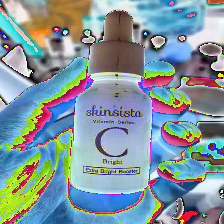

In [51]:
transform(anchor_img_pre['pixel_values'][0]*255)

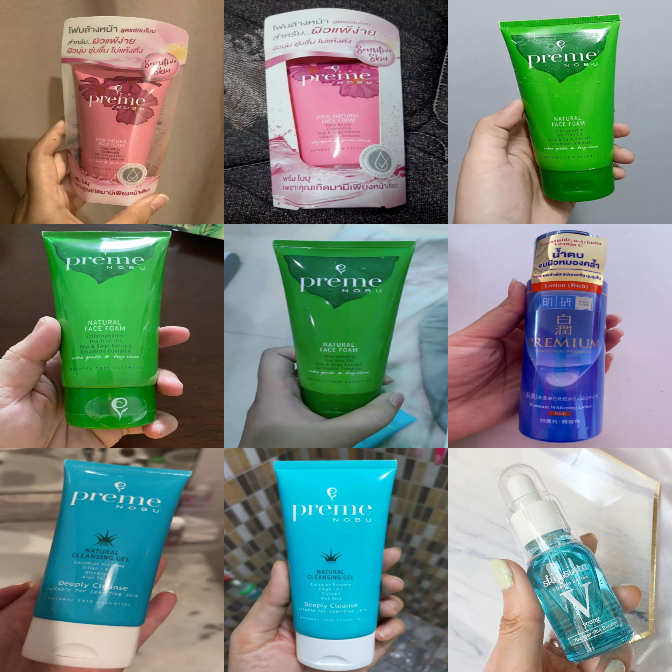

In [205]:
i=0
# anchor_img_pre['pixel_values'][i]*256
img = get_concat_h(transform(anchor_img[i]), transform(positive_img[i]))
img = get_concat_h(img, transform(negative_img[i]))
for i in range(1, BATCH_SIZE):
    temp = get_concat_h(transform(anchor_img[i]), transform(positive_img[i]))
    temp = get_concat_h(temp, transform(negative_img[i]))
    img = get_concat_v(img, temp)
img

In [29]:
anchor_out.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [14]:
anchor_out['pooler_output'].shape

torch.Size([6, 768])

In [37]:
anchor_out = vit_gg(anchor_img)

In [38]:
anchor_out.last_hidden_state.shape

torch.Size([3, 197, 768])